## dataset.py

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [03:13<00:00, 51252.25it/s] 


Extracting /home/wjc/mllm/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/wjc/mllm/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 96576.10it/s]


Extracting /home/wjc/mllm/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/wjc/mllm/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:15<00:00, 104042.67it/s]


Extracting /home/wjc/mllm/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/wjc/mllm/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9361439.20it/s]

Extracting /home/wjc/mllm/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/wjc/mllm/data/mnist/MNIST/raw

5


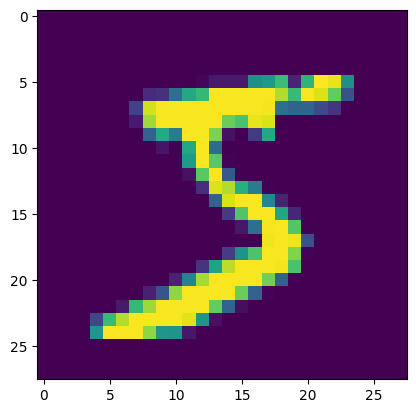

In [2]:
# PILToTensor 是 torchvision.transforms 模块中的一个类，用于将 PIL 图像转换为 PyTorch 的 Tensor
# 输入图像的格式通常是 (H x W x C)，即高度、宽度和通道数，转换后的 Tensor 的格式是 (C x H x W)，即通道数、高度和宽度。
# 这是因为 PyTorch 的 Tensor 在处理图像时，通道数是第一个维度。
# Compose 是 torchvision.transforms 模块中的另一个类，用于将多个图像变换操作组合在一起。它允许你将一系列的图像转换操作按顺序应用于输入图像。
from torch.utils.data import Dataset
from torchvision.transforms.v2 import PILToTensor,Compose
import torchvision

# 手写数字
class MNIST(Dataset):
    def __init__(self,is_train=True):
        super().__init__()
        self.ds=torchvision.datasets.MNIST('/home/wjc/mllm/data/mnist/',train=is_train,download=True)
        # img_convert(img) 返回的张量的值范围在 [0, 255] 之间。
        self.img_convert=Compose([
            PILToTensor(),
        ])
        
    def __len__(self):
        return len(self.ds)
    
    # 当通过 ds[0] 获取数据时，实际上是调用了 __getitem__ 方法。
    def __getitem__(self,index):
        img,label=self.ds[index]
        # 返回归一化后的图像 Tensor 和标签。
        return self.img_convert(img)/255.0,label
    
if __name__=='__main__':
    import matplotlib.pyplot as plt 
    
    ds=MNIST()
    img,label=ds[0]
    print(label)
    plt.imshow(img.permute(1,2,0))
    # plt.show()

## img_encoder.py

卷积核计算公式：https://www.cnblogs.com/zoubilin/p/17567156.

ReLU（Rectified Linear Unit）激活函数为网络引入非线性.当我们在网络的每一层之后使用 ReLU（或其他非线性激活函数）时，网络的输出不再是输入的简单线性组合。通过这种方式，网络能够表示和学习到更复杂的函数和模式。

    x = torch.randn(1, 1, 4, 4)  # 张量形状为 (1, 1, 4, 4)
    x_flattened = x.view(x.size(0), -1)  # 将张量展平成 (1, 16)
    print(x_flattened.shape)  # 输出: torch.Size([1, 16])

In [8]:
from torch import nn 
import torch 
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
        
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        
        self.conv3=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,padding=0,stride=stride)
    
    def forward(self,x):
        y=F.relu(self.bn1(self.conv1(x)))
        y=self.bn2(self.conv2(y))
        z=self.conv3(x)
        return F.relu(y+z)
        

class ImgEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.res_block1=ResidualBlock(in_channels=1,out_channels=16,stride=2) # (batch,16,14,14)
        self.res_block2=ResidualBlock(in_channels=16,out_channels=4,stride=2) # (batch,4,7,7)
        self.res_block3=ResidualBlock(in_channels=4,out_channels=1,stride=2) # (batch,1,4,4)
        self.wi=nn.Linear(in_features=16,out_features=8)
        self.ln=nn.LayerNorm(8)
        
    def forward(self,x):
        x=self.res_block1(x)
        x=self.res_block2(x)
        x=self.res_block3(x)
        # print(x.size(0))
        x=self.wi(x.view(x.size(0),-1))
        x=self.ln(x)
        return x
    
if __name__=='__main__':
    img_encoder=ImgEncoder()
    # 因为输入的图片张量是 1x28x28 的，所以输入的通道数是 1。
    out=img_encoder(torch.randn(1,1,28,28))
    print(out.shape)

1
torch.Size([1, 8])


## text_encoder.py

In [9]:
from torch import nn 
import torch 
import torch.nn.functional as F

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 一共只有十个数字，所以 num_embeddings=10。
        self.emb=nn.Embedding(num_embeddings=10,embedding_dim=16)
        self.dense1=nn.Linear(in_features=16,out_features=64)
        self.dense2=nn.Linear(in_features=64,out_features=16)
        self.wt=nn.Linear(in_features=16,out_features=8)
        self.ln=nn.LayerNorm(8)
    
    def forward(self,x):
        x=self.emb(x)
        x=F.relu(self.dense1(x))
        x=F.relu(self.dense2(x))
        x=self.wt(x)
        x=self.ln(x)
        return x

if __name__=='__main__':
    text_encoder=TextEncoder()
    x=torch.tensor([1,2,3,4,5,6,7,8,9,0])
    y=text_encoder(x)
    print(y.shape)

torch.Size([10, 8])


## CLIP.py
return img_emb @ text_emb.T 这行代码中的 @ 运算符表示矩阵乘法运算

In [11]:
from torch import nn 
import torch 
# from img_encoder import ImgEncoder
# from text_encoder import TextEncoder

class CLIP(nn.Module):
    def __init__(self,):
        super().__init__()
        self.img_enc=ImgEncoder()
        self.text_enc=TextEncoder()

    def forward(self,img_x,text_x):
        img_emb=self.img_enc(img_x)
        text_emb=self.text_enc(text_x)
        return img_emb@text_emb.T
    
if __name__=='__main__':
    clip=CLIP()
    img_x=torch.randn(5,1,28,28)
    text_x=torch.randint(0,10,(5,))
    logits=clip(img_x,text_x)
    print(logits.shape)

5
torch.Size([5, 5])


In [14]:
img_x

tensor([[[[-0.5934, -0.5750, -2.1580,  ...,  2.6855, -0.4067,  0.6574],
          [-1.5243, -1.4248, -0.2115,  ...,  1.7521,  0.1227,  0.6983],
          [ 1.0112,  0.8901, -0.1508,  ..., -1.2919,  0.4051, -2.7205],
          ...,
          [ 1.1697, -1.4691, -1.2244,  ...,  0.0223,  2.1281,  0.5019],
          [ 0.2402, -1.5055, -1.3895,  ...,  1.5622, -0.4408,  0.4127],
          [ 1.5139, -0.0595, -0.3256,  ..., -0.3279,  0.7978, -0.2185]]],


        [[[ 0.8510, -0.5536, -0.7077,  ..., -0.9314,  1.1319, -0.0356],
          [ 1.4177,  1.1410, -1.3114,  ..., -0.5541, -0.6159,  0.9672],
          [-0.7171, -1.5755, -1.3565,  ..., -1.4452,  0.0304,  0.5849],
          ...,
          [-0.3193, -0.1108,  1.1973,  ..., -0.5583,  0.4985, -0.3087],
          [-0.5008,  0.5747,  0.3786,  ...,  0.0545, -2.0439,  0.2778],
          [ 0.5941, -0.4259, -0.0944,  ...,  0.1799, -0.1880, -0.0904]]],


        [[[ 1.4839,  0.7221, -0.6917,  ..., -0.5925, -0.6376, -2.2693],
          [ 0.2986, -1.030

In [12]:
text_x

tensor([0, 2, 8, 7, 4])

In [13]:
logits

tensor([[2.8960, 5.9459, 5.8762, 3.0344, 4.1567],
        [4.9482, 2.3083, 4.1040, 2.1235, 5.0371],
        [5.1619, 6.9312, 7.6726, 4.1178, 6.4024],
        [4.0675, 2.9430, 2.3627, 4.7666, 1.0974],
        [2.6265, 4.9236, 4.9821, 2.3780, 2.8426]], grad_fn=<MmBackward0>)

## train.py

In [ ]:
import torch 
from dataset import MNIST
# from clip import CLIP
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os 

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'   # 设备

dataset=MNIST() # 数据集

model=CLIP().to(DEVICE) # 模型

try:    # 加载模型
    model.load_state_dict(torch.load('model.pth'))
except:
    pass 

optimzer=torch.optim.Adam(model.parameters(),lr=1e-3)   # 优化器

'''
    训练模型
'''
ITER_BATCH_COUNT=100000    # 迭代次数
BATCH_SIZE=64   # 从batch内选出10个不一样的数字
TARGET_COUNT=10 # 共10种数字

dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=10,persistent_workers=True)    # 数据加载器

for i in range(ITER_BATCH_COUNT):
    while True:
        imgs,labels=next(iter(dataloader))
        if torch.unique(labels).shape[0]<TARGET_COUNT:  # 未覆盖10种数字
            continue
        # 挑选出10个数字
        target=set()    
        indexes=[]
        for j in range(BATCH_SIZE):
            if labels[j].item() in target:
                continue 
            target.add(labels[j].item())
            indexes.append(j)
            if len(target)==TARGET_COUNT:
                break
        imgs=imgs[indexes]
        labels=labels[indexes]
        break

    logits=model(imgs.to(DEVICE),labels.to(DEVICE))
    
    targets=torch.arange(0,TARGET_COUNT).to(DEVICE)
    loss_i=F.cross_entropy(logits,targets)
    loss_t=F.cross_entropy(logits.permute(1,0),targets)
    loss=(loss_i+loss_t)/2
    
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
    if i%1000==0:
        print('iter:{},loss:{}'.format(i,loss))
        torch.save(model.state_dict(),'.model.pth')
        os.replace('.model.pth','model.pth')